In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import pickle
import numpy as np
import pandas as pd
from comparers import ModelComparer, plot_decision_boundary
from diro2c_wrapper import WrappedDiro2C, plot_diro2c_2d, get_pruned_trees, eval_diro2c, get_generated_data
from surrogate_tree import get_feature_importances, plot_feature_importances, plot_surrogate_tree,\
                           extract_rules, print_rules, plot_tree_leafs_for_class
from util import RuleClassifier, evaluate_counterfactual_fidelity, get_complexity, group_metrics
from tasks.boston_housing import make_task4 as make_task

In [2]:
clf_a, clf_b, X, y, feature_names, categorical_features, feature_precisions = make_task()

Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [4]:
mclass_diff = comparer.predict_mclass_diff(X)

# Explanations

In [ ]:
%%time
for class_name in comparer.class_names:
    print(class_name)
    explainer = WrappedDiro2C(X, comparer, class_name)
    explanation = explainer.generate_global_explanation()
    with open(f'diro2c-data/diro2c.{class_name}.pickle', 'wb') as f:
        pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

This was run on a different machine (Intel(R) Xeon(R) CPU E5-2676 v3 @ 2.40GHz):
- (0, 0)... 0:09:14.142372
- (0, 1)... 0:18:27.901131
- (0, 2)... 0:27:40.599932
- (1, 0)... 0:36:53.883956
- (1, 1)... 0:46:07.664046
- (1, 2)... 0:55:20.979274
- (2, 0)... 1:04:33.389025
- (2, 1)... 1:13:44.625557
- (2, 2)... 1:22:59.605905

## $(0,1)$

In [22]:
focus_class = '(0, 1)'
y_true = comparer.class_names[mclass_diff] == focus_class
class_names = ['other', focus_class]

In [23]:
with open(f'diro2c-data/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

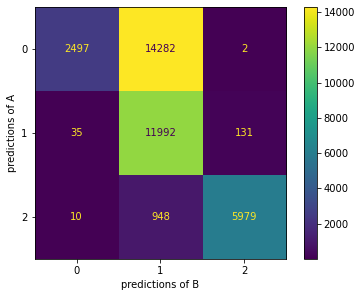

In [26]:
comparer.plot_confusion_matrix(get_generated_data(explanation)[0])
plt.savefig('boston4-diro2c-cf-01.pdf')

In [7]:
%%time
trees = get_pruned_trees(explanation)
tree_it = iter(trees)
len(trees)

CPU times: user 1min 37s, sys: 816 ms, total: 1min 38s
Wall time: 1min 46s


405

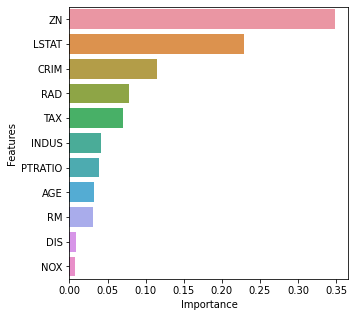

In [8]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))

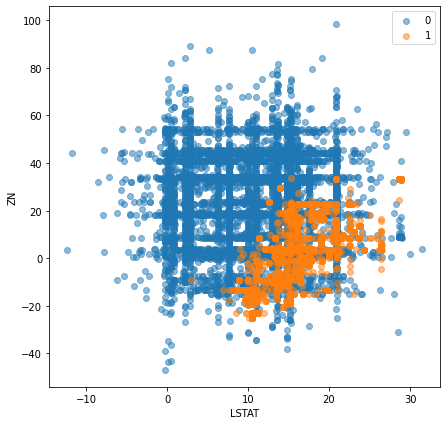

In [9]:
plot_diro2c_2d(explanation, 'LSTAT', 'ZN')

### 2 Leafs

In [10]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.07929222674267628, 1, 2)

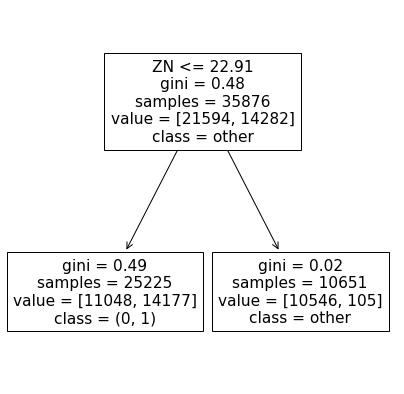

In [11]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [12]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. ZN <= 22.91230869293213 => (0, 1) [11048, 14177]


### 4 Leafs

In [13]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.01952841542162531, 3, 4)

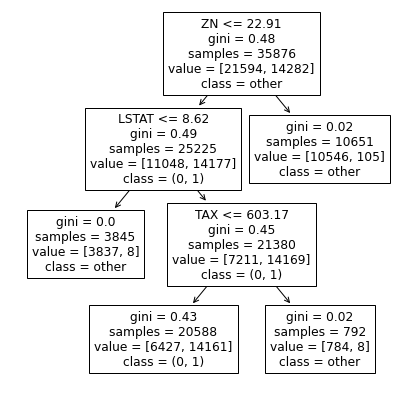

In [14]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [15]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. ZN <= 22.91230869293213 and TAX <= 603.1732482910156 and LSTAT > 8.620407104492188 => (0, 1) [6427, 14161]


### 6 Leafs

In [16]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.016842069506450202, 5, 6)

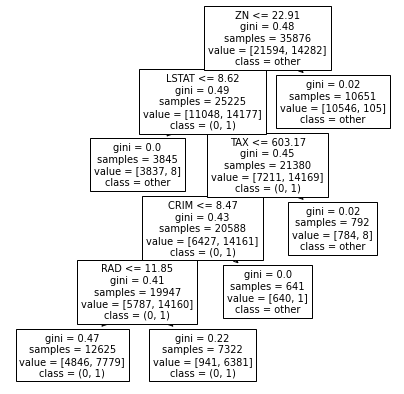

In [17]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [18]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. CRIM <= 8.467501163482666 and ZN <= 22.91230869293213 and RAD <= 11.851316928863525 and TAX <= 603.1732482910156 and LSTAT > 8.620407104492188 => (0, 1) [4846, 7779]
2. CRIM <= 8.467501163482666 and ZN <= 22.91230869293213 and RAD > 11.851316928863525 and TAX <= 603.1732482910156 and LSTAT > 8.620407104492188 => (0, 1) [941, 6381]


### 10 Leafs

In [19]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.01144991864646933, 9, 10)

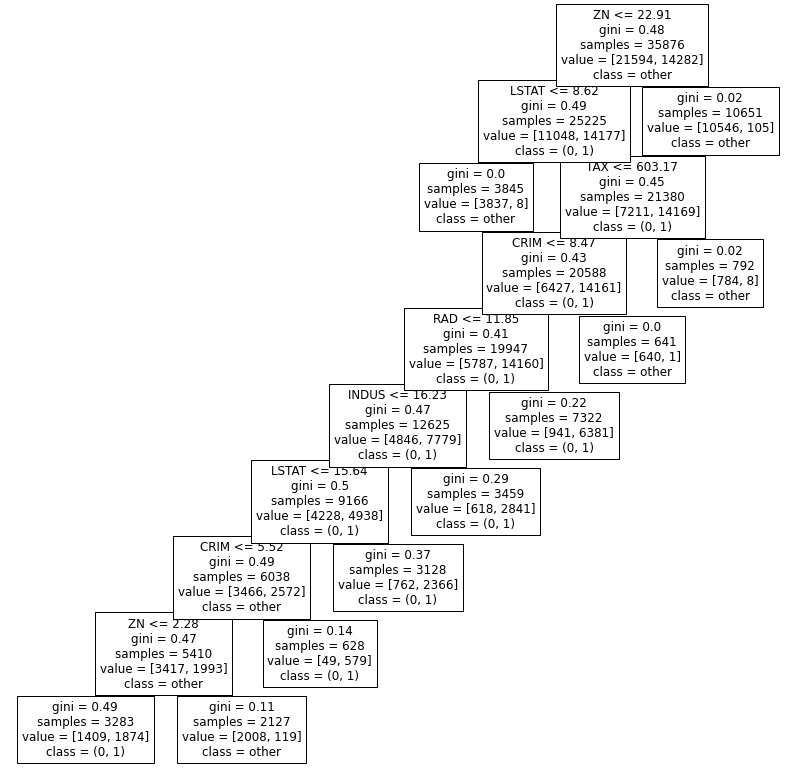

In [20]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(14, 14))

In [21]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. CRIM <= 8.467501163482666 and ZN <= 22.91230869293213 and RAD > 11.851316928863525 and TAX <= 603.1732482910156 and LSTAT > 8.620407104492188 => (0, 1) [941, 6381]
2. CRIM <= 8.467501163482666 and ZN <= 22.91230869293213 and INDUS > 16.22784996032715 and RAD <= 11.851316928863525 and TAX <= 603.1732482910156 and LSTAT > 8.620407104492188 => (0, 1) [618, 2841]
3. CRIM <= 5.524147987365723 and ZN <= 2.282783031463623 and INDUS <= 16.22784996032715 and RAD <= 11.851316928863525 and TAX <= 603.1732482910156 and 8.620407104492188 < LSTAT <= 15.641727924346924 => (0, 1) [1409, 1874]
4. CRIM <= 8.467501163482666 and ZN <= 22.91230869293213 and INDUS <= 16.22784996032715 and RAD <= 11.851316928863525 and TAX <= 603.1732482910156 and LSTAT > 15.641727924346924 => (0, 1) [762, 2366]
5. 5.524147987365723 < CRIM <= 8.467501163482666 and ZN <= 22.91230869293213 and INDUS <= 16.22784996032715 and RAD <= 11.851316928863525 and TAX <= 603.1732482910156 and 8.620407104492188 < LSTAT <= 15.6417279243

## $(1,0)$

In [27]:
focus_class = '(1, 0)'
y_true = comparer.class_names[mclass_diff] == focus_class
class_names = ['other', focus_class]

In [28]:
with open(f'diro2c-data/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

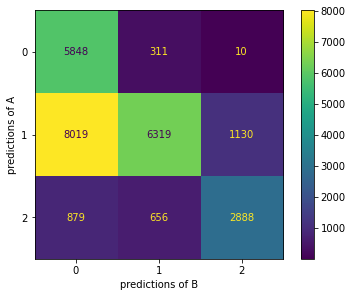

In [29]:
comparer.plot_confusion_matrix(get_generated_data(explanation)[0])
plt.savefig('boston4-diro2c-cf-10.pdf')

In [30]:
%%time
trees = get_pruned_trees(explanation)
tree_it = iter(trees)
len(trees)

CPU times: user 52.2 s, sys: 614 ms, total: 52.8 s
Wall time: 1min


352

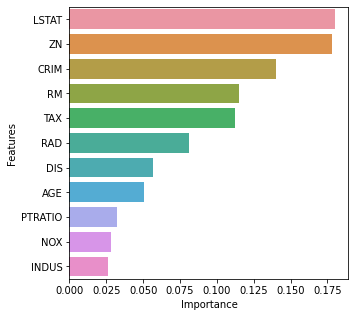

In [33]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))

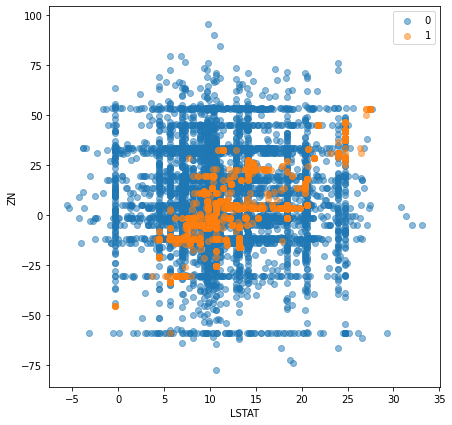

In [34]:
plot_diro2c_2d(explanation, 'LSTAT', 'ZN')

### 2 Leafs

In [35]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.02370747063194481, 1, 2)

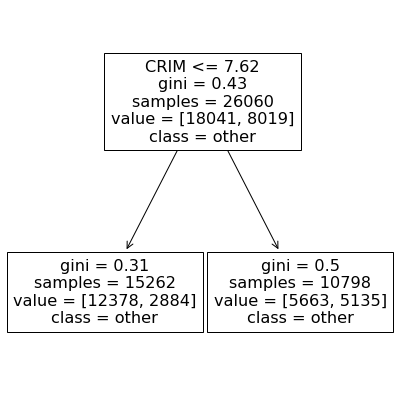

In [36]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [37]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

### 4 Leafs

In [38]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.021560687680527435, 3, 4)

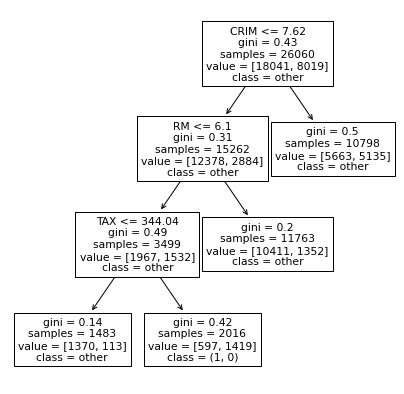

In [39]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [40]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. CRIM <= 7.622556686401367 and RM <= 6.102749824523926 and TAX > 344.0362854003906 => (1, 0) [597, 1419]


### 5 Leafs

In [41]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.01929482125314738, 3, 5)

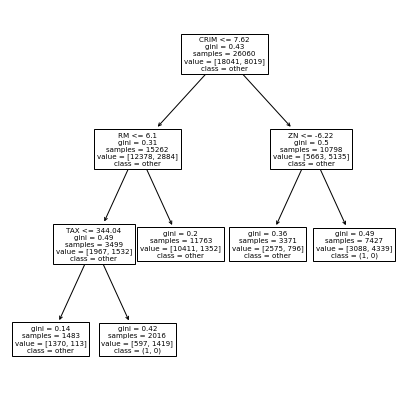

In [42]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [43]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. CRIM > 7.622556686401367 and ZN > -6.224346160888672 => (1, 0) [3088, 4339]
2. CRIM <= 7.622556686401367 and RM <= 6.102749824523926 and TAX > 344.0362854003906 => (1, 0) [597, 1419]


## $(1,2)$

In [44]:
focus_class = '(1, 2)'
y_true = comparer.class_names[mclass_diff] == focus_class
class_names = ['other', focus_class]

In [45]:
with open(f'diro2c-data/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

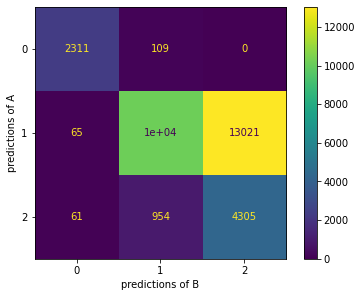

In [46]:
comparer.plot_confusion_matrix(get_generated_data(explanation)[0])
plt.savefig('boston4-diro2c-cf-12.pdf')

In [47]:
%%time
trees = get_pruned_trees(explanation)
tree_it = iter(trees)
len(trees)

CPU times: user 1min 8s, sys: 406 ms, total: 1min 8s
Wall time: 1min 10s


362

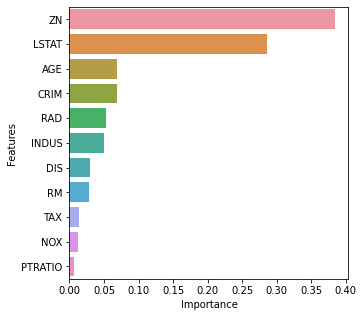

In [48]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))

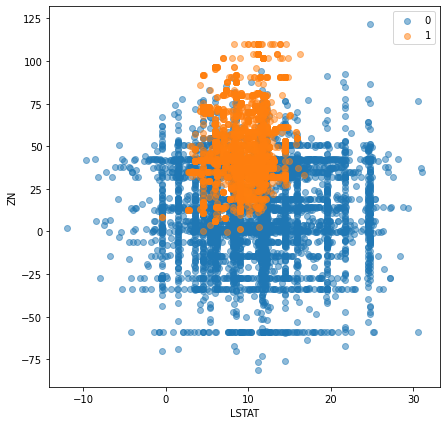

In [49]:
plot_diro2c_2d(explanation, 'LSTAT', 'ZN')

### 2 Leafs

In [50]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.07037882762220427, 1, 2)

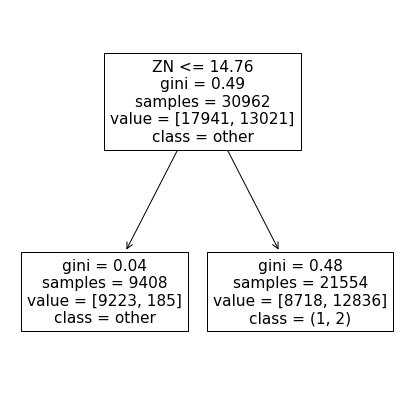

In [51]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [52]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. ZN > 14.764628887176514 => (1, 2) [8718, 12836]


### 3 Leafs

In [53]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.03796445320005154, 2, 3)

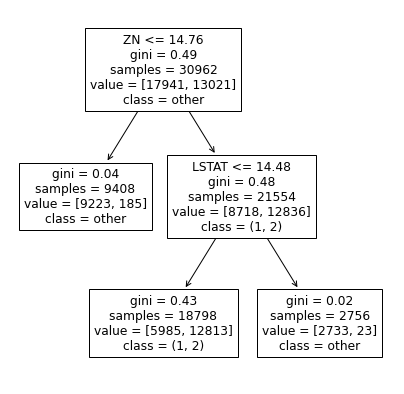

In [54]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [55]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. ZN > 14.764628887176514 and LSTAT <= 14.476411819458008 => (1, 2) [5985, 12813]


### 4 Leafs

In [56]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.025041631344524, 3, 4)

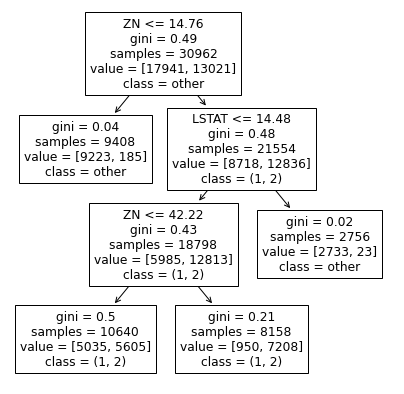

In [57]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [58]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. 14.764628887176514 < ZN <= 42.220123291015625 and LSTAT <= 14.476411819458008 => (1, 2) [5035, 5605]
2. ZN > 42.220123291015625 and LSTAT <= 14.476411819458008 => (1, 2) [950, 7208]


### 5 Leafs

In [59]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.020235002450197048, 4, 5)

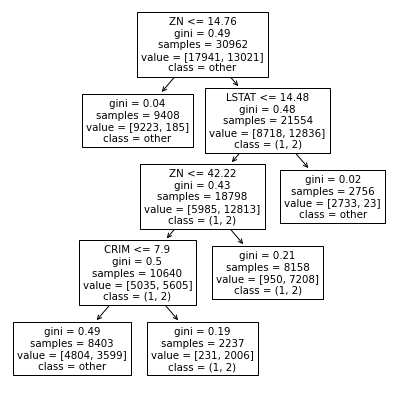

In [60]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [61]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. ZN > 42.220123291015625 and LSTAT <= 14.476411819458008 => (1, 2) [950, 7208]
2. CRIM > 7.90057897567749 and 14.764628887176514 < ZN <= 42.220123291015625 and LSTAT <= 14.476411819458008 => (1, 2) [231, 2006]


### 7 Leafs

In [62]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.01892509952509975, 6, 7)

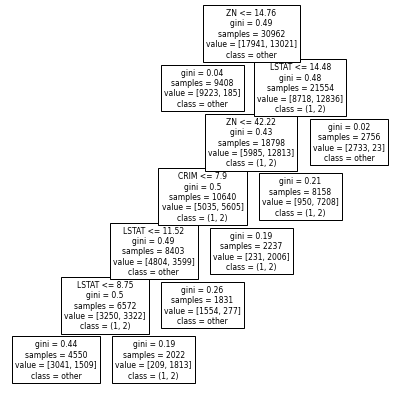

In [63]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [64]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. ZN > 42.220123291015625 and LSTAT <= 14.476411819458008 => (1, 2) [950, 7208]
2. CRIM > 7.90057897567749 and 14.764628887176514 < ZN <= 42.220123291015625 and LSTAT <= 14.476411819458008 => (1, 2) [231, 2006]
3. CRIM <= 7.90057897567749 and 14.764628887176514 < ZN <= 42.220123291015625 and 8.748027324676514 < LSTAT <= 11.516464233398438 => (1, 2) [209, 1813]


### 8 Leafs

In [65]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.009485846580884992, 6, 8)

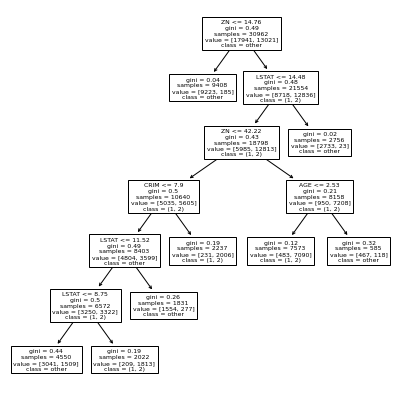

In [66]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [67]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. ZN > 42.220123291015625 and AGE <= 2.5329872369766235 and LSTAT <= 14.476411819458008 => (1, 2) [483, 7090]
2. CRIM > 7.90057897567749 and 14.764628887176514 < ZN <= 42.220123291015625 and LSTAT <= 14.476411819458008 => (1, 2) [231, 2006]
3. CRIM <= 7.90057897567749 and 14.764628887176514 < ZN <= 42.220123291015625 and 8.748027324676514 < LSTAT <= 11.516464233398438 => (1, 2) [209, 1813]


## $(2,1)$

In [68]:
focus_class = '(2, 1)'
y_true = comparer.class_names[mclass_diff] == focus_class
class_names = ['other', focus_class]

In [69]:
with open(f'diro2c-data/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

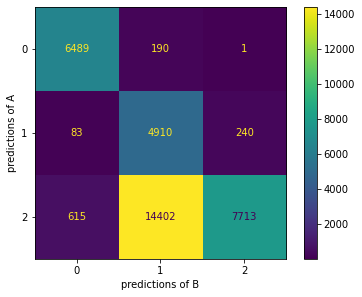

In [70]:
comparer.plot_confusion_matrix(get_generated_data(explanation)[0])
plt.savefig('boston4-diro2c-cf-21.pdf')

In [71]:
%%time
trees = get_pruned_trees(explanation)
tree_it = iter(trees)
len(trees)

CPU times: user 2min 7s, sys: 1.33 s, total: 2min 8s
Wall time: 2min 26s


535

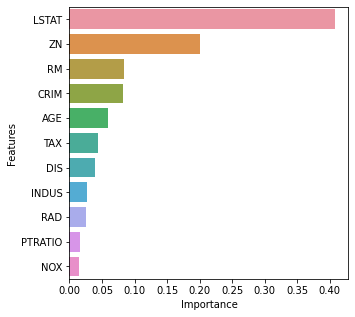

In [72]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))

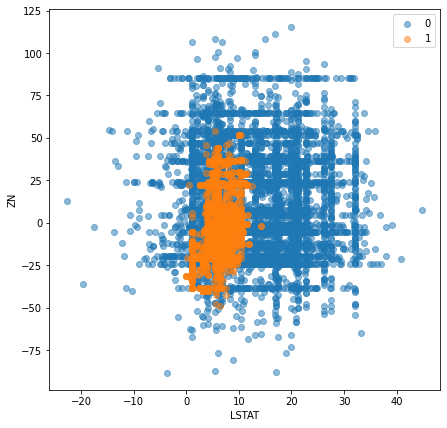

In [73]:
plot_diro2c_2d(explanation, 'LSTAT', 'ZN')

### 2 Leafs

In [88]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.07283219940974339, 1, 2)

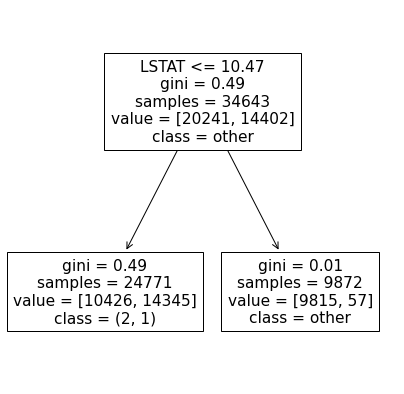

In [89]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [90]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. LSTAT <= 10.468215942382812 => (2, 1) [10426, 14345]


### 5 Leafs

In [91]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.02132784731827797, 4, 5)

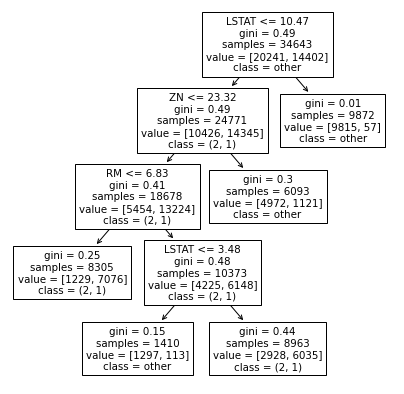

In [92]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [93]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. ZN <= 23.320544242858887 and RM > 6.833311319351196 and 3.482370376586914 < LSTAT <= 10.468215942382812 => (2, 1) [2928, 6035]
2. ZN <= 23.320544242858887 and RM <= 6.833311319351196 and LSTAT <= 10.468215942382812 => (2, 1) [1229, 7076]


### 6 Leafs

In [94]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.011261578007316655, 4, 6)

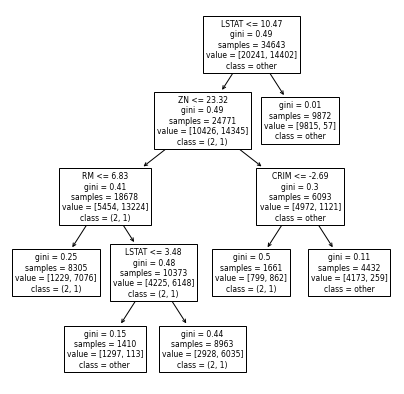

In [95]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [96]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. ZN <= 23.320544242858887 and RM > 6.833311319351196 and 3.482370376586914 < LSTAT <= 10.468215942382812 => (2, 1) [2928, 6035]
2. ZN <= 23.320544242858887 and RM <= 6.833311319351196 and LSTAT <= 10.468215942382812 => (2, 1) [1229, 7076]
3. CRIM <= -2.691372036933899 and ZN > 23.320544242858887 and LSTAT <= 10.468215942382812 => (2, 1) [799, 862]


### 9 Leafs

In [97]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.009694813963588005, 6, 9)

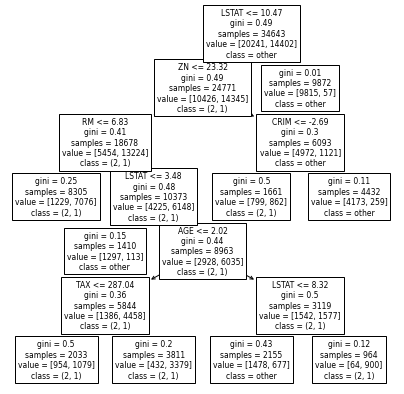

In [98]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [99]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. ZN <= 23.320544242858887 and RM <= 6.833311319351196 and LSTAT <= 10.468215942382812 => (2, 1) [1229, 7076]
2. ZN <= 23.320544242858887 and RM > 6.833311319351196 and AGE <= 2.016437292098999 and TAX > 287.0425567626953 and 3.482370376586914 < LSTAT <= 10.468215942382812 => (2, 1) [432, 3379]
3. ZN <= 23.320544242858887 and RM > 6.833311319351196 and AGE <= 2.016437292098999 and TAX <= 287.0425567626953 and 3.482370376586914 < LSTAT <= 10.468215942382812 => (2, 1) [954, 1079]
4. CRIM <= -2.691372036933899 and ZN > 23.320544242858887 and LSTAT <= 10.468215942382812 => (2, 1) [799, 862]
5. ZN <= 23.320544242858887 and RM > 6.833311319351196 and AGE > 2.016437292098999 and 8.31606149673462 < LSTAT <= 10.468215942382812 => (2, 1) [64, 900]
